## Auto-Encoding Variational Bayes
**Diederik P.Kingma et al., 2014.**

### Why manifold learning?
- Generative model을 학습한다는 것 = Plausible output을 잘 내는것?
- Generative model은 $p(x)$ 자체를 학습
- Arbitrary gaussian noise에서 plausible output을 낼 확률은 극히 드물다.
- 이를테면 Image의 200X200 pixel 조합 중에서 plausible output은 일부에 불과한데, 이러한 조합들을 포괄하는 manifold가 존재한다는 manifold hypothesis <br/>
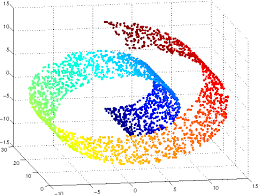</img> <br/>
- VAE는 manifold를 학습한 이후, 학습한 latent space에서의 sampling을 통해서 plausible output을 생성하는 것이 목표이다.

### Previous Challenges
- Posterior distributions of continuouslatent variables & parameters are intractable.
    - $p_\theta(x), p_\theta{(z|x)}$ 모두 intractable
- Efficient approximate posterior inference in directed probabilistic model is required.

### Contributions
- Derive a differentiable, unbiased estimator : lower bound estimator(ELBO) that can be used in optimizing stochastic gradient methods.
- Efficient posterior inference by fitting an approximate inference model, especially powerful in large datasets.
-  ```Core of VAE``` : Variational inference를 활용해 distribution의 학습 문제를 paramter optimization으로 바꾸고, posterior $q(z|x)$와 likelihood $p(x|z)$를 encoder와 decoder로 바꾸어 Neural Network를 모델링한 다음 Gradient Descent를 활용해 update하자.

### Problem Statement
- Efficient approximate ML or MAP estimation, for the parameters $\theta$.
- Efficient approximate posterior inference of the latent variable $z$ when observed value $x$ is given for a choice of parameters $\theta$.
- Efficient approximate marginal inference of the variable $x$(이것을 아는 것이 사실 최종 목표).

### Method
#### 01. Problem scenario
- samples $X$ consisting N i.i.d continuous or discreate variable $x$
- $X$ is sampled from unobserved continous random variable $z$
    - assume prior distribution of $z$ as $p_\theta^*(z)$, value $x^{(i)}$ generated from conditional distribution $p_\theta^*(x|z)$
    - true parameter $\theta^*$ and latent variables $z^{(i)}$ are hidden
    - we only know the output $x$ when paramter $\theta$ is chosen for generation.
- introduce recognition model $q_\phi{(z|x)}$ for approximation of true intractable posterior $p_\theta(z|x)$.
> Remark: Is this idea novel one? Mean-field variational inference
> - Variational Bayesian 관점에서 Mean-field approximation이 이미 제시된 바 있음
> - Approximate $p(\theta|x)$ with $g(\theta|\phi)$
> - Assume $g(\theta|\phi)$ is separable : $g(\theta|\phi) = \prod_{j=1}^{J} g_j(\theta_j|\phi_j)$, and $\phi^* = arg \min_\phi KL(g(\theta|\phi)||p(\theta|x))$
> - Not all distributions are seperable in parameters.

- inspiration of VAE architecture <br/>
    <img src = "https://user-images.githubusercontent.com/75057952/158972925-e275505a-602e-4383-afc0-22204b0ee1c0.png" width = "600dp"></img>

#### 02. Variational bound derivation
- $\log p_\theta(X) = \log p_\theta(x^{(1)}, ..., x^{(N)}) = \sum_{i=1}^N \log p_\theta(x^{(i)})$

**Proof 1 : Based on paper** <br/>
- $\log p(x) = \log p(x) \int q(z|x)dz = \int q(z|x) \log p(x) dz$
- **By bayes theorem**, $\int q(z|x) \log p(x) dz = \int q(z|x) \log{p(x|z)p(z) \over p(z|x)}dz \\ = \int q(z|x) {[\log p(x|z) + \log p(z) - \log p(z|x)]} dz \\ =  \int q(z|x) \log p(x|z) + \int q(z|x) \log p(z) dz - \int q(z|x) \log p(z|x_i) dz \pm \int q(z|x) \log q(z|x) dz \\ = \mathbb{E}_{q(z|x)}[\log p(x|z)] + {[\int q(z|x) \log p(z) dz - \int q(z|x) \log q(z|x) dz]} + {[\int q(z|x) \log q(z|x) dz-\int q(z|x) \log p(z|x) dz]} \\ = \mathbb{E}_{q(z|x)}[\log p(x|z)] + KL(q(z|x)||p(z|x)) \text{ (intractable) } - KL(q(x|z)||p(z) \text{ (tractable if we suppose gaussian dist.) } \\ \geq \mathbb{E}_{q(z|x)}[\log p(x|z)] - KL(q(x|z)||p(z)) = \mathcal L\text{ (i.e. ELBO)}$

**Proof 2 : Shortcut with jensen inequality** <br/>
- $\log p(x) = \log(\int{{p(x,z) \over q_\phi(z|x)}q_\phi(z|x)dz) = \log (\mathbb E_{q_\phi(z|x)}[{p(x,z) \over q_\phi(z|x)}])\geq \mathbb E_{q_\phi(z|x)}{[\log {p(x,z) \over q_\phi(z|x)}]}}: \text{by Jensen Inequality}$
- $\mathbb E_{q_\phi(z|x)}{[\log {p(x,z) \over q_\phi(z|x)}]}  = \mathbb E_{q_\phi(z|x)}{[\log {p(x|z)p(z) \over q_\phi(z|x)}]}\\  = E_{q_\phi(z|x)}{[\log {p(x|z)}]} - E_{q_\phi(z|x)}{[{q_\phi(z|x) \over p(z)}]} \\ = E_{q_\phi(z|x)}{[\log {p(x|z)}]} - \int {q_\phi(z|x) \over p(z)}q_\phi(z|x) dz \\ = E_{q_\phi(z|x)}{[\log {p(x|z)}]} - KL(q_\phi(z|x)||p(z)) = \mathcal L\text{ (i.e. ELBO)}$

**Thus,**
<img src = "https://user-images.githubusercontent.com/75057952/158972941-2451f4a4-d182-4782-baa9-2e02e59e5f65.png" width = "600dp"></img>
- Expectation value의 gradient 자체를 Monte Carlo estimation으로 추정하여 update에 활용할 때는 sampled gradient value의 variance가 매우 높다는 문제가 있음.
- Expectation value를 reparametrizing trick을 통해 변환하고, Monte Carlo expectation value 자체를 estimate하여 neural network에서의 gradient descent를 통해 paramter update가 가능함.

### 03. SGVB estimator,  AEVB algorithm and reparamterization trick

- 위의 식에서 ELBO Term을 구했고, ELBO를 object function으로 두고 parmeter update가 필요함. 이때 Gradient을 어떻게 계산할까?
- 우선 Stochastic Sampling을 통하게 되는 순간 expectation value가 q에 dependent하던 조건이 사라지는 문제가 발생함.
- 그리고 Expectation value의 gradient 자체를 Monte Carlo estimation으로 추정하여 update에 활용할 때는 sampled gradient value의 variance가 매우 높다는 문제가 있음.
- Expectation value를 reparametrizing trick을 통해 변환하면 z가 아닌 $\epsilon$에 stochasticy가 더해지고, z는 q로부터 직접 sampling됨.
- 그리고 Monte Carlo expectation value 자체를 estimate하여 neural network에서의 gradient descent를 통해 paramter update가 가능 :  ```contribution of SGVB estimator```
- random variable $z$를 $x$와 error(auxiliary) noise variable $\epsilon$에 의존적인 term으로 가정(여기서는 *Gaussian Dist.*) <br/>
<img src = "https://user-images.githubusercontent.com/75057952/158972850-9d8dd10b-3cd4-4ed6-9c4d-c66c241d9466.png" width = "700dp"></img>

- AEVB algorithm <br/>
<img src = "https://user-images.githubusercontent.com/75057952/158973022-4d3e95b0-ad7a-4bb6-b279-640fd8eb7137.png" width = "500dp"></img>

### 04. Example : Univariate gaussian-distribution case
### Remark : $q(z|x) \text{ as encoder }, p(x|z) \text{ as decoder} $
**Encoder**
- suppose $z ∼ p(z|x) = N (\mu, \sigma^2)$ : Gaussian Encoder
- valid reparameterization : $z = \mu + \sigma\epsilon$, where $\epsilon$ is an auxiliary noise variable $\epsilon ∼ N (0, 1)$. 
- Therefore, $\mathbb E_{N(z;\mu,\sigma^2)} [f(z)] = \mathbb E_{N(\epsilon;0,1)}[f(\mu + \sigma\epsilon)] \sim {1 \over L} \sum_{i=1}^L f(\mu + \sigma\epsilon^{(l)}) \text{ where } \epsilon^{(l)} \sim N(0,1)$
- ELBO is calculated as... (KL term can be explicitly calculated if gaussian, thus we can apply estimator B !!!) <br/>
<img src = "https://user-images.githubusercontent.com/75057952/158973037-53fc9efc-fb6d-4c6f-8064-bb617a3d8248.png" width = "380dp"></img>
<img src = "https://user-images.githubusercontent.com/75057952/158973047-a1e92cfb-3eb9-4dfd-8428-778977770e30.png" width = "500dp"></img>

**Decoder** : Bernoulli MLP and Gaussian MLP
- 인코더의 역할이 latent space로의 임베딩을 '잘' 만드는 것이라면, 디코더의 역할은 latent space에서 sampling된 z로부터 생성된 output이 실제 p(x)를 반영하여 잘 만들어지기를 목표로 함.